# <center>K-means Clustering and Principal Component Analysis</center>

In the first half of this exercise, you will be using K-means clustering algorithm and apply it to compress an image. In the next half of the exercise, you will be using component analysis to find a low-dimensional representation of face images.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import scipy.io
from scipy.spatial.distance import cdist
from scipy import linalg
from sklearn import preprocessing
from sklearn.decomposition import PCA

## K-means Clustering

### Implementing K-Means on an example 2D Dataset

2D Example Dataset which will help gain an intuition of how the K-means algorithm works.

dict_keys(['__header__', '__version__', '__globals__', 'X'])
(300, 2)


[Text(0.5, 0, 'Example data 2')]

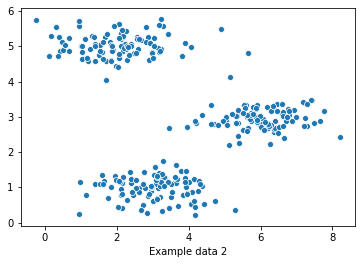

In [2]:
data = scipy.io.loadmat('ex7data2.mat')
print(data.keys())
X = data['X']
print(X.shape)
fig_data2 = plt.figure()
ax_data2 = fig_data2.add_subplot(111) 
ax_data2 = sns.scatterplot(x=X.T[0], y=X.T[1])
ax_data2.set(xlabel='Example data 2')

In [3]:
# Function to calculate closest centroids using Eucledian distance
def findClosestCentroids(X, initial_centroids):
    dist_arr = cdist(X, initial_centroids)
    return (np.argmin(dist_arr, axis=1))

In [4]:
# Function to update cluster centroid to the mean of all points in the cluster
def updateCentroid(X, closest_centroids, K):
    # Array to hold updated centroids
    updated_centroids = np.empty((0,X.shape[1]))
    for i in range(K):
        X_sub = X[closest_centroids == i]
        # Drop any centroids that don't have any points
        if(X_sub.size > 0):
            avg = np.mean(X_sub, axis=0).reshape(1, X.shape[1])
            updated_centroids = np.append(updated_centroids, avg, axis=0)
    return updated_centroids

In [5]:
# Main function to run K-Means Clustering
def runkmeans(X, K, max_iter, initial_centroids):
    # Array to hold list of centroids used to visualize in plot
    cx, cy = initial_centroids.shape[0], initial_centroids.shape[1]
    centroid_list = np.empty((0, cx, cy), int)
    centroid_list = np.append(centroid_list, initial_centroids.reshape(1, cx, cy), axis=0)
    for i in range(max_iter):
        # Cluster Assignment by finding closest centroids
        closest_centroids_idx = findClosestCentroids(X, initial_centroids)
        # Update centroid
        updated_centroids = updateCentroid(X, closest_centroids_idx, K)
        centroid_list = np.append(centroid_list, updated_centroids.reshape(1, cx, cy), axis=0)
        initial_centroids = updated_centroids
    return (closest_centroids_idx, updated_centroids, centroid_list)

Text(0.5, 0.98, 'K-Mean Clustering K = 3')

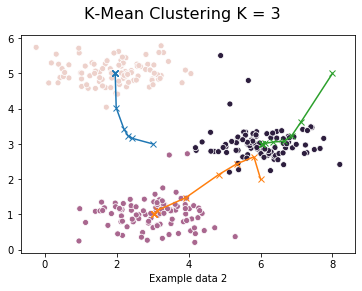

In [6]:
# Run K-Means on sample 2D dataset
K = 3
max_iter = 10
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])
(closest_centroids_idx, updated_centroids, centroid_list) = runkmeans(X, K, max_iter, initial_centroids)

fig_data22 = plt.figure()
ax_data22 = fig_data22.add_subplot(111) 
ax_data22 = sns.scatterplot(x=X.T[0], y=X.T[1], hue=closest_centroids_idx)
for i in range(K):
    #ax_data22 = sns.lineplot(x=centroid_list[:,i,0], y=centroid_list[:,i,1], marker='x')
    ax_data22.plot(centroid_list[:,i,0], centroid_list[:,i,1], marker='x')
ax_data22.set(xlabel='Example data 2')
ax_data22.get_legend().remove()
title = "K-Mean Clustering K = {}".format(K)
fig_data22.suptitle(title, fontsize=16)

#### Random initialization of centroids

In [7]:
def initRandomCentroid(X, K):
    ind = np.random.randint(X.shape[0], size=K)
    return X[ind]

### Image compressions with K-Means


In normal image, each pixel is represented by three 8-bit unsigned int (total 24 bits) for Red, Green and Blue intensity values. One image contains 1000s of colors.
In this compression, we are going to reduce to only 16 colors (represented by 4 bits) and each pixels will store only the index of the color.
To achieve this using K-Means, run K-Means for 16 clusters to get the 16 colors that best represent the pixels.

In [8]:
# Reading image using .mat file
imgmat = scipy.io.loadmat('bird_small.mat')
print(imgmat.keys())
img1 = imgmat['A']
print(img1.shape, np.min(img1), np.max(img1))

dict_keys(['__header__', '__version__', '__globals__', 'A'])
(128, 128, 3) 6 255


In [9]:
# Reading image file directly
img2 = mpimg.imread('bird_small.png')
print(img2.shape, np.min(img2), np.max(img2))

(128, 128, 3) 0.023529412 1.0


Text(0.5, 1.0, 'Compressed with 16 colors')

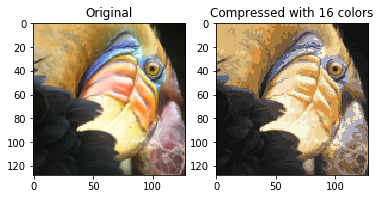

In [10]:
# Run K-Means on image data
img = img2
#img = img1/255 - Normalize the image to scale all points 0 - 1
imgX = img.reshape(img.shape[0]*img.shape[1],3)

K = 16
max_iter = 10

# Calculate initial centroid randomly
initial_centroids = initRandomCentroid(imgX, K)

# Run K-Means to calculate 16 cluster and its centroids
(closest_centroids_idx, updated_centroids, centroid_list) = runkmeans(imgX, K, max_iter, initial_centroids)
# Find closest cluster members
closest_centroids_idx = findClosestCentroids(imgX, updated_centroids)

# With 'K' Cluster indexes, we can replace each pixel in the image
# with the the corresponding cluster centroid to get compressed version
imgC = updated_centroids[closest_centroids_idx,:].reshape(img.shape[0],img.shape[1],3)

# View original and compressed side by side
fig_data1 = plt.figure()
ax_data11 = fig_data1.add_subplot(121) 
ax_data11.imshow(img)
ax_data11.set_title("Original")
ax_data12 = fig_data1.add_subplot(122) 
ax_data12.imshow(imgC)
title = "Compressed with {} colors".format(K)
ax_data12.set_title(title)

## Principal Component Analysis

We will use principal component analysis (PCA) to perform dimensionality reduction. First experiment with an example 2D dataset to get intuition on how PCA works, and then use it on a bigger dataset of 5000 face image dataset.

### Example Dataset

In [11]:
# Reading example dataset
pcadata = scipy.io.loadmat('ex7data1.mat')
print(pcadata.keys())
pcaX = pcadata['X']
print(pcaX.shape)

dict_keys(['__header__', '__version__', '__globals__', 'X'])
(50, 2)


In [12]:
# Function to plot two charts
#   1. Original data and its principal components
#   2. Normalized data and and projected data, and connect these points
def plotPCA(X, X_scaled, X_approx, eigenvectors, eigenvalues, num_comp, method):
   # Get eigen vector plotting points
    center = np.mean(X, axis=0).reshape(1,2)
    vector_cood = np.vstack((center, center+(eigenvectors*eigenvalues.reshape(2,1)*1.5)))
    
    fig_pcadata1 = plt.figure(figsize=(10, 6))
    ax_pcadata1 = fig_pcadata1.add_subplot(121)
    # Plot Original data
    ax_pcadata1 = sns.scatterplot(x=X.T[0], y=X.T[1], color='blue')
    # Plot eigen vector
    for i in range(eigenvectors.shape[0]):
        ax_pcadata1.plot(vector_cood[[0,i+1],0], vector_cood[[0,i+1],1], color='black', marker='x')
    title = "Original data and its principal components"
    ax_pcadata1.set_title(title, fontsize=8)
    
    ax_pcadata2 = fig_pcadata1.add_subplot(122)
    # Plot normalized data
    ax_pcadata2 = sns.scatterplot(x=X_scaled.T[0], y=X_scaled.T[1], color='blue')
    # Plot Approximated data
    ax_pcadata2 = sns.scatterplot(x=X_approx.T[0], y=X_approx.T[1], color='red')
    # Draw lines connecting the projected points to the original points
    lines = np.hstack
    for i in range(X_scaled.shape[0]):
        ax_pcadata2.plot([X_scaled[i][0], X_approx[i][0]], [X_scaled[i][1], X_approx[i][1]], 'k--', linewidth=1)
    title = "Normalized data and and projected data after {}".format(method)
    ax_pcadata2.set_title(title, fontsize=8)

#### Projected data onto its principal components

We project the normalized data onto its 'K' principal components (eigen vectors - U).
$$ U\_reduce = U(:K, :) $$
$$ X\_reduce = U\_reduce.X^T$$
$$U - n x n, U\_reduce - K x n, X - m x n, X\_reduce - K x m $$

In [13]:
def projectData(X_scaled, eigenvectors, num_comp):
    U_reduce = eigenvectors[:num_comp,:]
    X_reduce = U_reduce.dot(X_scaled.T)
    return X_reduce.T

#### Reconstructing an approximation of the data

We reconstruct an approximate version of normalized data onto its 'K' principal components (eigen vectors - U).
$$ U\_reduce = U(:K, :) $$
$$ X\_approx = X\_reduce^T.U\_reduce$$
$$ U\_reduce - K x n, X\_reduce - K x m, X\_approx - m x n $$

In [14]:
def recoverData(X_reduce, eigenvectors, num_comp):
    U_reduce = eigenvectors[:num_comp,:]
    X_approx = X_reduce.dot(U_reduce)
    return X_approx

#### Implement PCA using scikit-learn and SVD

In [15]:
# PCA using scikit-learn library
def runPCA(X, X_scaled, num_comp, print_comp, plot):
    print("PCA using scikit-learn")
    num_dim = X.shape[1]
    
    # Init PCA with desired number of components
    #pca = PCA(n_components=num_comp)
    pca = PCA()
    
    # Reduce dimension
    principalComponents = pca.fit_transform(X_scaled)
   
    # Print Eigen vector/values and variance explained by different components
    eigenvectors = pca.components_
    eigenvalues = pca.explained_variance_
    expvariances = pca.explained_variance_ratio_
    if(print_comp):
        for id, (expvariance, eigenvector, eigenvalue) in enumerate(zip(expvariances, eigenvectors, eigenvalues)):
            print("Component {} - Explained Variance {}, Eigenvector {}, Eigenvalue {}".format(id, expvariance, eigenvector, eigenvalue))
    
    # Get projected and approximate recovered data
    X_reduce = projectData(X_scaled, eigenvectors, num_comp)
    X_approx = recoverData(X_reduce, eigenvectors, num_comp)
    
    # Plot the original data and reduced data
    if(plot and num_dim == 2 and num_comp == 1):
        plotPCA(X, X_scaled, X_approx, eigenvectors, eigenvalues, num_comp, "PCA")
        
    return (X_reduce, X_approx, eigenvectors, eigenvalues)

In [16]:
# PCA using covariance matrix and its singular value decomposition
def runSVD(X, X_scaled, num_comp, print_comp, plot):
    print("PCA using covariance matrix and its singular value decomposition")
    num_dim = X.shape[1]
    
    # Calculate covariance matrix
    cvm = np.cov(X_scaled.T)
    
    # Run singular value decomposition
    (U, S, V) = linalg.svd(cvm)
    if(print_comp):
        for id, (eigenvector, eigenvalue) in enumerate(zip(U, S)):
            print("Component {} - Eigenvector {}, Eigenvalue {}".format(id, eigenvector, eigenvalue))
    
    # Get projected and approximate recovered data
    X_reduce = projectData(X_scaled, U, num_comp)
    X_approx = recoverData(X_reduce, U, num_comp)
    
    # Plot the original data and reduced data
    if(plot and num_dim == 2 and num_comp == 1):
        plotPCA(X, X_scaled, X_approx, U, S, num_comp, "SVD")
        
    return (X_reduce, X_approx, U, S)

PCA using scikit-learn
Component 0 - Explained Variance 0.8677651881696649, Eigenvector [-0.70710678 -0.70710678], Eigenvalue 1.770949363611561
Component 1 - Explained Variance 0.1322348118303352, Eigenvector [-0.70710678  0.70710678], Eigenvalue 0.26986696291905143
PCA using covariance matrix and its singular value decomposition
Component 0 - Eigenvector [-0.70710678 -0.70710678], Eigenvalue 1.7709493636115605
Component 1 - Eigenvector [-0.70710678  0.70710678], Eigenvalue 0.26986696291905093


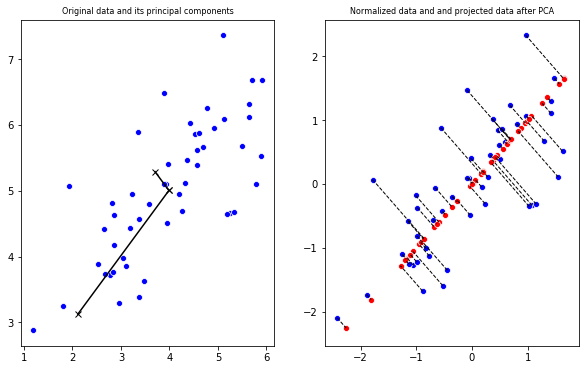

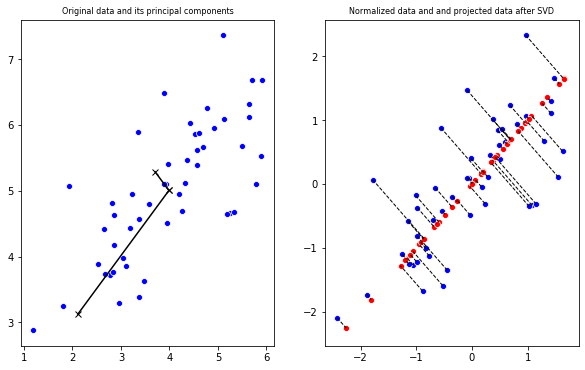

In [17]:
# Run both PCA versions on the example dataset
num_comp = 1
# Normalize the data
pcaX_scaled = preprocessing.scale(pcaX)
(pcaX_reduce,  pcaX_approx,  pcaX_eigenvectors,  pcaX_eigenvalues)  = runPCA(pcaX, pcaX_scaled, num_comp, 1, 1)
(pcaX_reduce2, pcaX_approx2, pcaX_eigenvectors2, pcaX_eigenvalues2) = runSVD(pcaX, pcaX_scaled, num_comp, 1, 1)

### Face Image Dataset

Run PCA on face images to see how it can be used in practice for dimension reduction. The dataset has 5000 images each of size 32 x 32 (1024) pixels

In [18]:
# Reading face image dataset
facedata = scipy.io.loadmat('ex7faces.mat')
print(facedata.keys())
faceX = facedata['X']
print(faceX.shape)

dict_keys(['__header__', '__version__', '__globals__', 'X'])
(5000, 1024)


Function to get display image

In [19]:
def getDisplayImage(X):
    numpixels1d = X.shape[1]
    numpixels2d = int(np.sqrt(numpixels1d))

    num_img = X.shape[0]
    rows = cols = int(np.sqrt(num_img))
    
    pad = 1
    patch = np.zeros((pad + (pad+numpixels2d)*rows, pad + (pad+numpixels2d)*cols))

    for i in range(num_img):
        row, col = i // rows, i % rows
        img = X[i].reshape(numpixels2d, numpixels2d)
        row_start, row_end = pad + row*(pad+numpixels2d),  (row+1)*(pad+numpixels2d)
        col_start, col_end = pad + col*(pad+numpixels2d),  (col+1)*(pad+numpixels2d)
        patch[row_start : row_end , col_start : col_end] = img.T
    return patch

In [20]:
# Run PCA on face dataset
num_comp = 100
# Normalize the data
faceX_scaled = preprocessing.scale(faceX)
(faceX_reduce, faceX_approx, faceX_eigenvectors, faceX_eigenvalues) = runPCA(faceX, faceX_scaled, num_comp, 0, 0)

PCA using scikit-learn


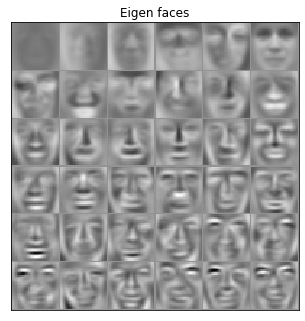

In [21]:
# PLot eigen faces for first 36 principal components
eigen_patch = getDisplayImage(faceX_eigenvectors[:36,:])

fig_patchfacedata1 = plt.figure()

ax_patchfacedata1 = fig_patchfacedata1.add_subplot(111)
fig_patchfacedata1.subplots_adjust(left=0,right=1,bottom=0,top=1)
ax_patchfacedata1.imshow(eigen_patch, cmap='gray', origin="upper")
ax_patchfacedata1.set_title("Eigen faces")

ax_patchfacedata1.axes.xaxis.set_visible(False)
ax_patchfacedata1.axes.yaxis.set_visible(False)

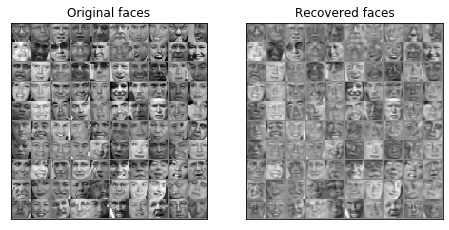

In [22]:
# Plot original and recovered images
original_patch = getDisplayImage(faceX[:100,:])
recovered_patch = getDisplayImage(faceX_approx[:100,:])

fig_facedata1 = plt.figure()
fig_facedata1.subplots_adjust(left=0,right=1,bottom=0,top=1)
ax_facedata1 = fig_facedata1.add_subplot(121)
ax_facedata1.imshow(original_patch, cmap='gray', origin="upper")
ax_facedata1.set_title("Original faces")

ax_facedata2 = fig_facedata1.add_subplot(122)
ax_facedata2.imshow(recovered_patch, cmap='gray', origin="upper")
ax_facedata2.set_title("Recovered faces")

ax_facedata1.axes.xaxis.set_visible(False)
ax_facedata1.axes.yaxis.set_visible(False)
ax_facedata2.axes.xaxis.set_visible(False)
ax_facedata2.axes.yaxis.set_visible(False)

### PCA for visualization

Visualize the final cluster assignments (obtained using K-Means) of pixels in the bird image in 3D space (RBG components). Then reduce it to 2D and visualize it in 2D space

In [23]:
# Run K-Means on image data
img = img2
imgX = img.reshape(img.shape[0]*img.shape[1],3)

K = 16
max_iter = 10

# Calculate initial centroid randomly
initial_centroids = initRandomCentroid(imgX, K)

# Run K-Means to calculate 16 cluster and its centroids
(closest_centroids_idx, updated_centroids, centroid_list) = runkmeans(imgX, K, max_iter, initial_centroids)

In [24]:
# Get 1000 random pixels
num_samples = 1000
indices = np.random.randint(0,imgX.shape[0], size=num_samples)

In [25]:
# Get a colormap based on the number of clusters 'K'
# and assign one color to each cluster index
R = np.linspace(0,1,num=K)
palette = plt.cm.hsv(R)
colors = palette[closest_centroids_idx[indices], :]

Text(0.5, 0.92, 'Visualize cluster membership for each pixel in 3D')

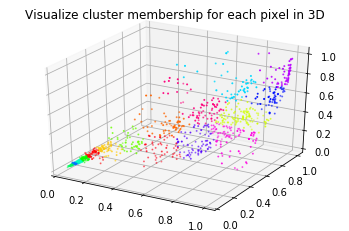

In [26]:
# Plot cluster assigmnents in 3D space
fig_imgX = plt.figure()
ax_imgX = fig_imgX.add_subplot(111, projection='3d')
ax_imgX.scatter(imgX[indices,0], imgX[indices,1], imgX[indices,2], s=1, c=colors)
ax_imgX.set_title("Visualize cluster membership for each pixel in 3D")

In [27]:
# Run PCA to reduce to 2D
(imgX_reduce, imgX_approx, imgX_eigenvectors, imgX_eigenvalues) = runPCA(imgX, imgX, 2, 0, 0)

PCA using scikit-learn


Text(0.5, 1.0, 'Visualize cluster membership for each pixel in 2D')

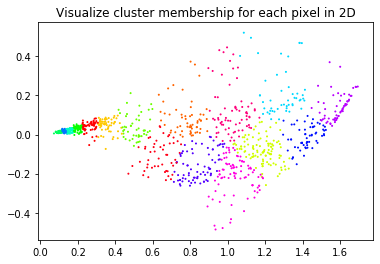

In [28]:
# Plot cluster assigmnents in 2D space
fig_imgX_reduce = plt.figure()
ax_imgX_reduce = fig_imgX_reduce.add_subplot(111)
ax_imgX_reduce.scatter(imgX_reduce[indices,0], imgX_reduce[indices,1], s=1, c=colors)
ax_imgX_reduce.set_title("Visualize cluster membership for each pixel in 2D")